In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import scipy.sparse as sp
import anndata as ad
import celltypist
import scanpy.external as sce

# Make AnnData objects from TSV files and concatenate objects

In [2]:
adata_bmp = sc.read_text("GSM7867719/GSM7867719_BMP4_D1.ali_13.tsv.gz")

In [3]:
adata_bmp

AnnData object with n_obs × n_vars = 1607 × 41861

In [4]:
adata_bmp.obs["condition"] = "BMP4_D1"

In [5]:
adata_none = sc.read_text("GSM7867719/GSM7867719_None_D1.ali_13.tsv.gz")

In [6]:
adata_none

AnnData object with n_obs × n_vars = 2561 × 41861

In [7]:
adata_none.obs["condition"] = "None_D1"

In [8]:
adata = ad.concat([adata_bmp, adata_none], join="outer", index_unique="-")

In [9]:
adata.X = sp.csr_matrix(adata.X)

In [10]:
sc.pp.filter_genes(adata, min_counts=1)
sc.pp.filter_genes(adata, min_cells=1)
adata.var["log10_n_counts"] = np.log10(adata.var.n_counts)
adata.var["log10_n_cells"] = np.log10(adata.var.n_cells)

In [11]:
sc.pp.filter_cells(adata, min_counts=1)
sc.pp.filter_cells(adata, min_genes=1)
adata.obs["log10_n_counts"] = np.log10(adata.obs.n_counts)
adata.obs["log10_n_gene"] = np.log10(adata.obs.n_genes)

In [12]:
adata

AnnData object with n_obs × n_vars = 4168 × 26096
    obs: 'condition', 'n_counts', 'n_genes', 'log10_n_counts', 'log10_n_gene'
    var: 'n_counts', 'n_cells', 'log10_n_counts', 'log10_n_cells'

In [13]:
adata.write_h5ad(f"adata_raw.h5ad", compression="gzip")

... storing 'condition' as categorical


# Filtering genes and cells

In [14]:
adata = sc.read("adata_raw.h5ad")

## Gene filtering

#### We perform very mild removal of genes based on total counts and the number of cells in which they are expressed, especially given how small the dataset is.

In [15]:
sc.pp.filter_genes(adata, min_counts=5)

In [16]:
sc.pp.filter_genes(adata, min_cells=3)

<Axes: xlabel='log10_n_counts', ylabel='Count'>

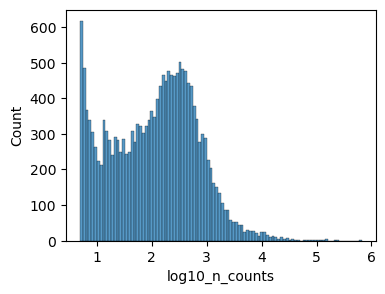

In [17]:
plt.rcParams["figure.figsize"] = (4, 3)
sns.histplot(adata.var["log10_n_counts"], bins=100)

<Axes: xlabel='log10_n_cells', ylabel='Count'>

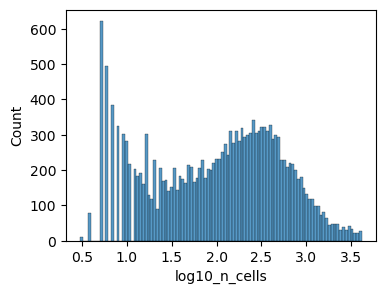

In [18]:
plt.rcParams["figure.figsize"] = (4, 3)
sns.histplot(adata.var["log10_n_cells"], bins=100)

In [19]:
adata

AnnData object with n_obs × n_vars = 4168 × 17766
    obs: 'condition', 'n_counts', 'n_genes', 'log10_n_counts', 'log10_n_gene'
    var: 'n_counts', 'n_cells', 'log10_n_counts', 'log10_n_cells'

## Cell filtering

<Axes: xlabel='log10_n_counts', ylabel='Count'>

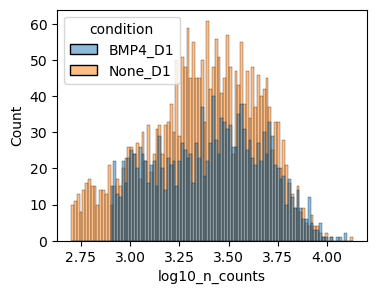

In [20]:
plt.rcParams["figure.figsize"] = (4, 3)
sns.histplot(data=adata.obs, x="log10_n_counts", bins=100, hue="condition")

#### It seems the data has been filtered to some extent, and at different levels for each condition.

In [21]:
adata[adata.obs["condition"] == "BMP4_D1"].obs.n_counts.min()

np.float32(800.0)

In [22]:
adata[adata.obs["condition"] == "None_D1"].obs.n_counts.min()

np.float32(502.0)

<Axes: xlabel='log10_n_gene', ylabel='Count'>

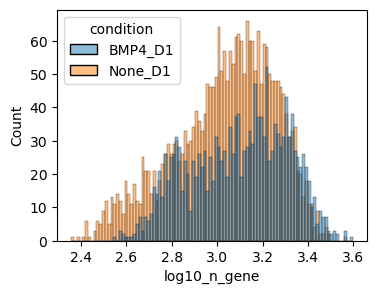

In [23]:
plt.rcParams["figure.figsize"] = (4, 3)
sns.histplot(data=adata.obs, x="log10_n_gene", bins=100, hue="condition")

### Around 2.7 seems like a good spot for filtering based on gene counts, which is a better measure of quality than transcript counts. Also, the few cells with many genes could be indicative of doublets, so filtering at 3.5 on the log10 scale is reasonable. With so few cells, the doublet rate should be minimal.

In [24]:
10**2.7

501.18723362727246

In [25]:
sc.pp.filter_cells(adata, min_genes=10**2.7)

In [26]:
sc.pp.filter_cells(adata, max_genes=10**3.5)

<Axes: xlabel='log10_n_gene', ylabel='Count'>

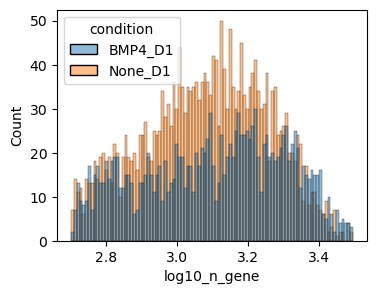

In [27]:
plt.rcParams["figure.figsize"] = (4, 3)
sns.histplot(data=adata.obs, x="log10_n_gene", bins=100, hue="condition")

## Mitochondrial transcript filtering

In [28]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")

In [29]:
adata.obs["mt_count"] = adata[:, adata.var_names.str.startswith("MT-")].X.sum(axis=1)

In [30]:
adata.obs["pct_mt_count"] = adata.obs["mt_count"] / adata.obs["n_counts"] * 100

<Axes: xlabel='log10_n_gene', ylabel='pct_mt_count'>

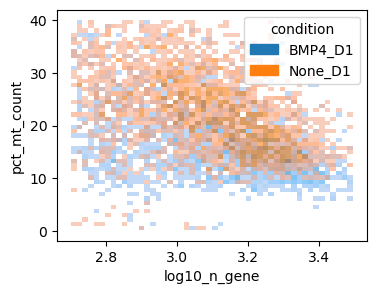

In [31]:
plt.rcParams["figure.figsize"] = (4, 3)
sns.histplot(
    data=adata.obs,
    x="log10_n_gene",
    y="pct_mt_count",
    bins=50,
    alpha=0.6,
    hue="condition",
)

### No strong threshold that would separate high-MT cells can be inferred, so we don't apply any filtering. Also, it seems that a threshold of 40% has already been applied.

# Variable genes selection

### We use `seurat_v3` method described in https://doi.org/10.1016/j.cell.2019.05.031 and outlined below:
...aimed to identify a subset of features (e.g., genes) exhibiting high variability across cells, and therefore represent heterogeneous features to prioritize for downstream analysis. Choosing genes solely based on their log-normalized single-cell variance fails to account for the mean-variance relationship that is inherent to single-cell RNA-seq. Therefore, we first applied a variance-stabilizing transformation to correct for this [Mayer et al., 2018; Hafemeister and Satija, 2019].
To learn the mean-variance relationship from the data, we computed the mean and variance of each gene using the unnormalized data (i.e., UMI or counts matrix), and applied log10-transformation to both. We then fit a curve to predict the variance of each gene as a function of its mean, by calculating a local fitting of polynomials of degree 2 (R function loess, span = 0.3). This global fit provided us with a regularized estimator of variance given the mean of a feature. As such, we could use it to standardize feature counts without removing higher-than-expected variation.
Given the expected variances, we performed the transformation
𝑧𝑖⁢𝑗=(𝑥𝑖⁢𝑗−𝑥𝑖)/𝜎𝑖 where 𝑧𝑖⁢𝑗 is the standardized value of feature i in cell j, 𝑥𝑖⁢𝑗 is the raw value of feature i in cell j, 𝑥𝑖 is the mean raw value for feature i, and 𝜎𝑖 is the expected standard deviation of feature i derived from the global mean-variance fit. To reduce the impact of technical outliers, we clipped the standardized values to a maximum value of √𝑁, where N is the total number of cells. For each gene, we then computed the variance of standardized values across all cells. This variance represents a measure of single-cell dispersion after controlling for mean expression, and we use it directly to rank the features.

### Other methods should yield similar results. This method has the ability to find variable genes within each batch (not enabled here), but it provides a ranking of genes that is helpful for understanding very global aspects of the data.

In [32]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=10000, inplace=True)

In [33]:
adata.write_h5ad("adata_filtered.h5ad", compression="gzip")

# Normalization, log transformation, and dimensionality reduction

In [34]:
adata = sc.read("adata_filtered.h5ad")

In [35]:
sc.pp.normalize_total(adata, target_sum=10000)
sc.pp.log1p(adata)

In [36]:
adata.raw = adata

#### We can select all genes for downstream analysis, but usually eliminating less variable genes helps in better resolving clusters. However, very small clusters might be lost due to the removal of their marker genes.

In [37]:
adata = adata[:, adata.var.highly_variable_rank < 5000].copy()

In [38]:
adata

AnnData object with n_obs × n_vars = 3863 × 5000
    obs: 'condition', 'n_counts', 'n_genes', 'log10_n_counts', 'log10_n_gene', 'mt_count', 'pct_mt_count'
    var: 'n_counts', 'n_cells', 'log10_n_counts', 'log10_n_cells', 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'

In [39]:
sc.pp.scale(adata, max_value=10)

In [40]:
sc.tl.pca(adata, n_comps=100)

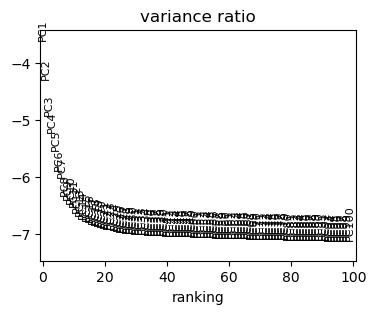

In [41]:
plt.rcParams["figure.figsize"] = (4, 3)
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=100)

In [42]:
adata = adata.raw.to_adata()

#### We select the number of PCs based on the plateau point of the `pca_variance_ratio` plot. Using too many PCs will fit the noise, while too few PCs will lose the major variation in the data.

#### Further testing of different parameters, such as `n_neighbors` and clustering `resolution`, is helpful when combined with other views of the cell types after further analysis. For UMAP, parameters are chosen to show more separated clusters by reducing `min_dist` while keeping data points from being too close to each other within each neighborhood using `spread`. Additionally, UMAP accuracy can be improved by running more iterations using `maxiter`.

In [43]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

In [44]:
sc.tl.umap(adata, min_dist=0.3, spread=1.5, maxiter=1000)

In [45]:
sc.tl.leiden(adata, resolution=0.5)

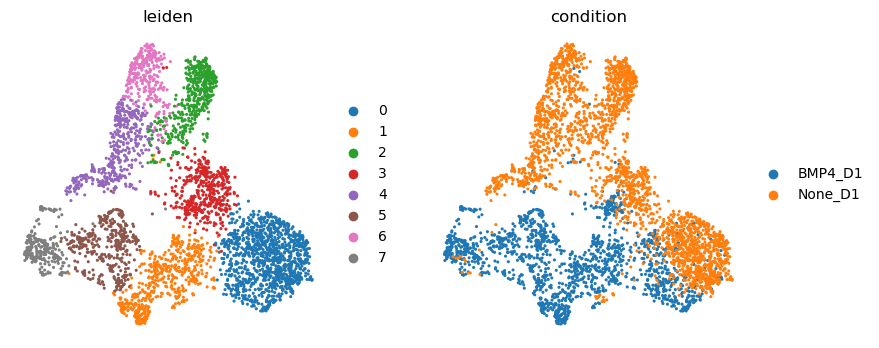

In [46]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["leiden", "condition"], s=20, frameon=False)

### We see major differences between the two conditions; this could be due to either batch effects or simply the effect of in vitro differentiation.

To understand the composition of the data, we look at the top 20 variable genes that are also expressed in many cells.

In [47]:
adata.var[adata.var.highly_variable_rank < 20].sort_values(
    by="log10_n_cells", ascending=False
).head(20)

n_counts  n_cells  log10_n_counts  log10_n_cells     mt  \
BPIFA1   208350.0     2287        5.318793       3.359266  False   
SCGB3A1   81593.0     1845        4.911653       3.265996  False   
KRT6A     32251.0     1504        4.508543       3.177248  False   
KRT13     25542.0     1432        4.407255       3.155943  False   
KRT10      7144.0     1090        3.853941       3.037426  False   
MT2A       2580.0      805        3.411620       2.905796  False   
SCGB1A1   13337.0      673        4.125058       2.828015  False   
SPRR1B     4180.0      655        3.621176       2.816241  False   
PI3        2975.0      651        3.473487       2.813581  False   
KRT6B      2097.0      546        3.321599       2.737193  False   
SPINK5     1671.0      497        3.222976       2.696356  False   
CXCL14     4389.0      486        3.642366       2.686636  False   
SPRR3      3007.0      415        3.478133       2.618048  False   
KRT16      3131.0      397        3.495683       2.598791  False   
FN1        6160.0      364        3.789581       2.561101  False   
KRT14      4701.0      336        3.672190       2.526339  False   
S100A8     1226.0      305        3.088490       2.484300  False   
CRYAB       809.0      254        2.907948       2.404834  False   
KRT6C      1252.0      119        3.097604       2.075547  False   
MUC5AC      443.0      115        2.646404       2.060698  False   

         highly_variable  highly_variable_rank      means     variances  \
BPIFA1              True                  17.0  52.549055  17560.812650   
SCGB3A1             True                  12.0  20.749418   3775.864173   
KRT6A               True                   7.0   8.163862   1011.116332   
KRT13               True                  15.0   6.531193    384.479024   
KRT10               True                   3.0   1.817499    147.995944   
MT2A                True                  18.0   0.645871     11.926865   
SCGB1A1             True                   0.0   3.388558    594.688186   
SPRR1B              True                  11.0   1.060834     26.665123   
PI3                 True                   9.0   0.752524     20.159351   
KRT6B               True                  10.0   0.535335     12.739753   
SPINK5              True                  19.0   0.426611      5.308893   
CXCL14              True                   5.0   1.114419     94.603684   
SPRR3               True                   4.0   0.755889     37.785811   
KRT16               True                   6.0   0.788765     36.628077   
FN1                 True                   2.0   1.574165     97.768644   
KRT14               True                   1.0   1.201139     71.730895   
S100A8              True                  14.0   0.310381      5.328548   
CRYAB               True                  13.0   0.206316      2.882073   
KRT6C               True                   8.0   0.323065     23.249823   
MUC5AC              True                  16.0   0.113642      2.012716   

         variances_norm  
BPIFA1         7.925128  
SCGB3A1       10.008519  
KRT6A         14.077212  
KRT13          8.168535  
KRT10         16.808631  
MT2A           7.745469  
SCGB1A1       22.836113  
SPRR1B        10.538940  
PI3           11.665760  
KRT6B         10.850609  
SPINK5         7.586028  
CXCL14        15.738755  
SPRR3         15.970235  
KRT16         15.168014  
FN1           18.548081  
KRT14         19.801949  
S100A8         8.903761  
CRYAB          9.083921  
KRT6C         12.625506  
MUC5AC         8.102074

### Consulting curated resources such as [Azimuth](https://azimuth.hubmapconsortium.org/references/) and [Human Protein Atlas](https://www.proteinatlas.org/) we find the majority of genes to be related to different types of epithelial cells. KRT6A and KRT13 are markers of basal cells, and BPIFA1 and SCGB3A1 are markers of secretory cells.

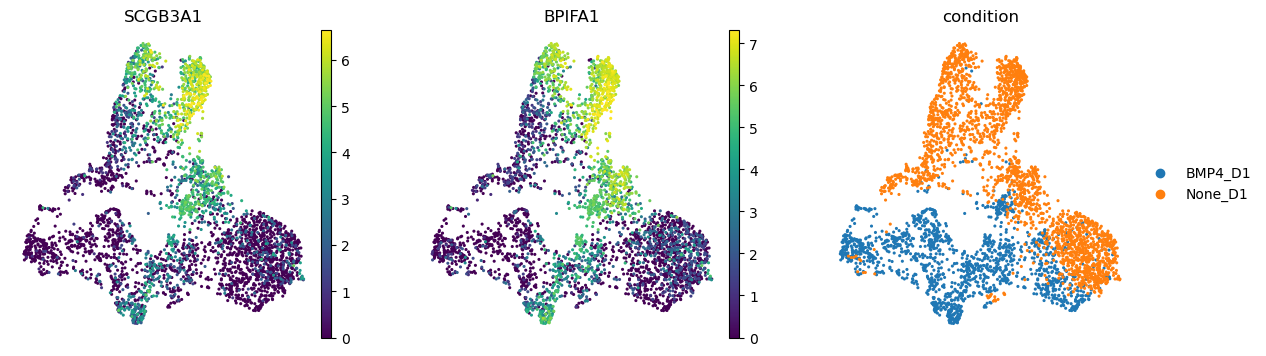

In [48]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(
    adata, color=["SCGB3A1", "BPIFA1", "condition"], s=20, vmax="p99.5", frameon=False
)

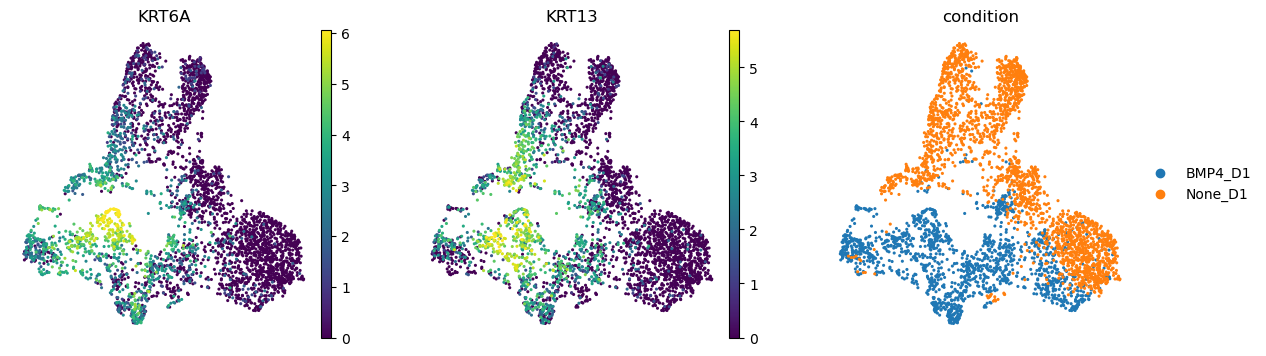

In [49]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(
    adata, color=["KRT6A", "KRT13", "condition"], s=20, vmax="p99.5", frameon=False
)

#### BMP4 treated cells seem to be enriched in basal state cells, and untreated cells enriched in secretory cells

#### Prompted by this, we can attempt to use the Human Lung Cell Atlas for preliminary cell type predictions. However, given the amount of variation, batch correction could help bring similar cells closer in the KNN graph derived from corrected principal components. We will use Harmony for this purpose.

In [50]:
sce.pp.harmony_integrate(adata, key="condition", max_iter_harmony=100)

2025-09-10 14:00:30,154 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2025-09-10 14:00:30,609 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2025-09-10 14:00:30,617 - harmonypy - INFO - Iteration 1 of 100
Iteration 1 of 100
2025-09-10 14:00:30,921 - harmonypy - INFO - Iteration 2 of 100
Iteration 2 of 100
2025-09-10 14:00:31,216 - harmonypy - INFO - Converged after 2 iterations
Converged after 2 iterations


In [51]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40, use_rep="X_pca_harmony")

In [52]:
sc.tl.umap(adata, min_dist=0.3, spread=1.5, maxiter=1000)

#### Different clustering resolution levels should be tested at this stage in an iterative manner by moving forward, annotating the cells, and going back to change the clustering to see if the clusters represent the biological variation. I eventually chose 0.7 ***after*** multiple iterations of the next steps of cell annotations and marker visualization.

In [53]:
sc.tl.leiden(adata, resolution=0.7)

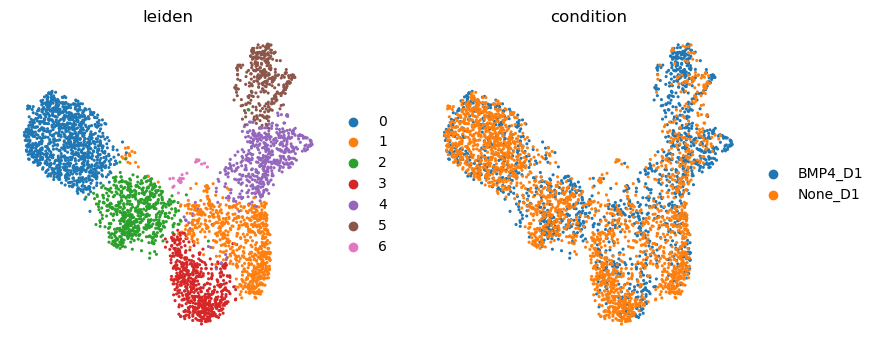

In [54]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["leiden", "condition"], s=20, frameon=False)

In [55]:
adata.obs = adata.obs[["condition", "log10_n_counts", "pct_mt_count", "leiden"]].copy()

# Cell type prediction using extrenal datasets

In [56]:
from celltypist import models

models_df = models.models_description()
models_df[models_df["description"].str.contains("lung|Lung")]

👉 Detailed model information can be found at `https://www.celltypist.org/models`


model  \
13      Autopsy_COVID19_Lung.pkl   
15  COVID19_Immune_Landscape.pkl   
17          Cells_Fetal_Lung.pkl   
20         Cells_Lung_Airway.pkl   
42            Human_IPF_Lung.pkl   
44          Human_Lung_Atlas.pkl   
45             Human_PF_Lung.pkl   
47       Lethal_COVID19_Lung.pkl   
52        Nuclei_Lung_Airway.pkl   

                                          description  
13  cell types from the lungs of 16 SARS-CoV-2 inf...  
15  immune subtypes from lung and blood of COVID-1...  
17    cell types from human embryonic and fetal lungs  
20  cell populations from scRNA-seq of five locati...  
42  cell types from idiopathic pulmonary fibrosis,...  
44  integrated Human Lung Cell Atlas (HLCA) combin...  
45  cell types from different forms of pulmonary f...  
47  cell types from the lungs of individuals who d...  
52  cell populations from snRNA-seq of five locati...

#### Models Cells_Lung_Airway and Human_Lung_Atlas seem like good choices to use for this dataset.

In [57]:
predictions = celltypist.annotate(
    adata, model="Human_Lung_Atlas.pkl", majority_voting=True
)

🔬 Input data has 3863 cells and 17766 genes
🔗 Matching reference genes in the model
🧬 4038 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


In [58]:
majority_voting_df = predictions.predicted_labels.majority_voting.copy()

In [59]:
majority_voting_df.name += "_Lung_Atlas"

In [60]:
adata.obs = adata.obs.join(majority_voting_df)

In [61]:
predictions = celltypist.annotate(
    adata, model="Cells_Lung_Airway.pkl", majority_voting=True
)

🔬 Input data has 3863 cells and 17766 genes
🔗 Matching reference genes in the model
🧬 4262 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


In [62]:
majority_voting_df = predictions.predicted_labels.majority_voting.copy()

In [63]:
majority_voting_df.name += "_Lung_Airway"

In [64]:
adata.obs = adata.obs.join(majority_voting_df)

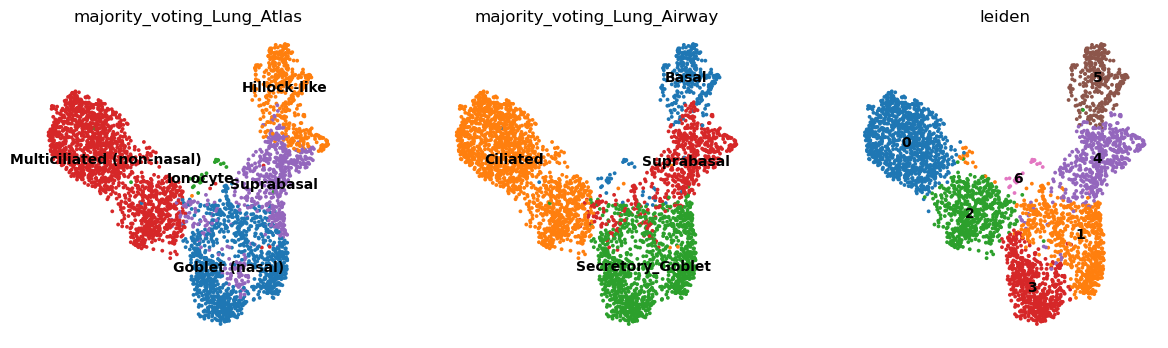

In [65]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(
    adata,
    color=["majority_voting_Lung_Atlas", "majority_voting_Lung_Airway", "leiden"],
    legend_loc="on data",
    s=30,
    frameon=False,
)

### The predictions align quite well with each other and with the unsupervised clusters. However, we cannot be sure if the predictions fully reflect true biology. The `Lung Atlas` prediction includes a rare population of Ionocytes, which needs further investigation. Additionally, the Hillock cell prediction seems off, while the `Lung Airway` prediction aligns better with a differentiation trajectory from basal to suprabasal cells. Unsupervised Leiden clustering appears to capture the rare cluster as well as subtypes of ciliated and secretory cells. We will use DEGs as the final method to confirm what is appropriate.

In [66]:
adata.write_h5ad("adata_clustering_harmony.h5ad", compression="gzip")

# Computing DEGs per cluster

In [67]:
adata = sc.read("adata_clustering_harmony.h5ad")

In [68]:
adata.uns["log1p"]["base"] = None
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon", key_added="leiden_DEG")

In [69]:
result = adata.uns["leiden_DEG"]
groups = result["names"].dtype.names
deg = pd.DataFrame(
    {
        group + "_" + key[:4]: result[key][group]
        for group in groups
        for key in ["names", "pvals_adj", "logfoldchanges"]
    }
)

#### We sort the DEGs based on the product of the log10 of p-value and the log fold change (logFC). This selects for genes that show both consistent and high levels of differential expression.

In [70]:
for i in groups:
    deg_sub = deg[[f"{i}_name", f"{i}_pval", f"{i}_logf"]].copy()
    deg_sub["logpval_mult_logf"] = -np.log10(
        deg_sub[f"{i}_pval"] + 10 ** (-300)
    ) * np.abs(deg_sub[f"{i}_logf"] ** 2)

    deg_sub = (
        deg_sub[(deg_sub[f"{i}_pval"] < 0.1) & (deg_sub[f"{i}_logf"] > 1)]
        .sort_values(by="logpval_mult_logf", ascending=False)
        .head(100)
    )
    print(f"c{i}: ", deg_sub[f"{i}_name"].to_list()[:20])

    deg_sub.to_csv(f"cluster_{i}_markers.csv", index=None)

c0:  ['TPPP3', 'C20orf85', 'CAPS', 'CCDC170', 'RSPH1', 'ALDH3A1', 'TUBB4B', 'CETN2', 'TUBA1A', 'AC007906.2', 'C9orf24', 'C9orf116', 'C1orf194', 'IGFBP7', 'PIFO', 'FOXJ1', 'C5orf49', 'ALDH3B1', 'CYP4B1', 'RRAD']
c1:  ['C3', 'CEACAM6', 'SERPINB3', 'CXCL8', 'SERPINA3', 'CXCL2', 'LCN2', 'SLC6A14', 'F3', 'AGR2', 'CXCL1', 'MUC1', 'IGFBP3', 'APOL1', 'EPAS1', 'LY6E', 'CP', 'STEAP4', 'WFDC2', 'S100P']
c2:  ['BPIFA1', 'BPIFB1', 'TPPP3', 'ALDH3A1', 'CAPS', 'SCGB3A1', 'TUBB4B', 'WFDC2', 'SLPI', 'MUC5B', 'SCGB1A1', 'H19', 'RSPH1', 'AC007906.2', 'C20orf85', 'TUBA1A', 'SERPINA3', 'TFF3', 'LRRC46']
c3:  ['BPIFA1', 'SCGB3A1', 'BPIFB1', 'CYP2F1', 'PIGR', 'SLPI', 'CTSC', 'SCGB1A1', 'MSMB', 'CEACAM6', 'XBP1', 'CXCL17', 'WFDC2', 'IL1R1', 'C3', 'CHP2', 'RDH10', 'IL6', 'GABRP', 'ATP12A']
c4:  ['KRT13', 'KRT5', 'KRT6A', 'SPRR1B', 'S100A2', 'PKP1', 'LYPD3', 'CSTA', 'FABP5', 'KRT16', 'KRT15', 'C10orf99', 'IL1RN', 'NECTIN1', 'SPINK5', 'DSP', 'SDC1', 'DSC3', 'UPK1B', 'HSPB1']
c5:  ['COL17A1', 'S100A2', 'FN1', 'CA

# Annotation of each cluster based on marker genes and literature search

### c0 is expressing known ciliated cell markers RSPH1 and FOXJ1, similar to [my past work](https://doi.org/10.1164/rccm.202310-1831LE), as well as TPPP3.

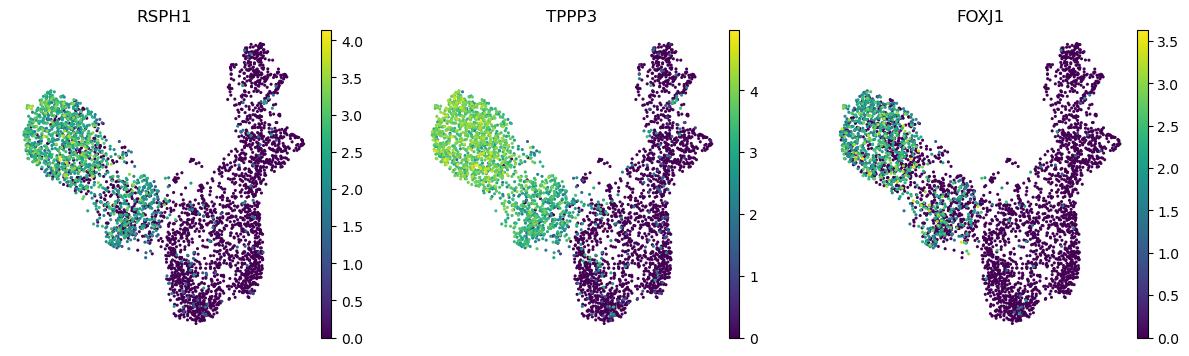

In [71]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["RSPH1", "TPPP3", "FOXJ1"], s=20, frameon=False)

### c2 shares the same common markers with c0; however, it also expresses secretory markers such as SCGB3A1, SCGB1A1, and BPIFA1, so we designate it as secretory ciliated cells.

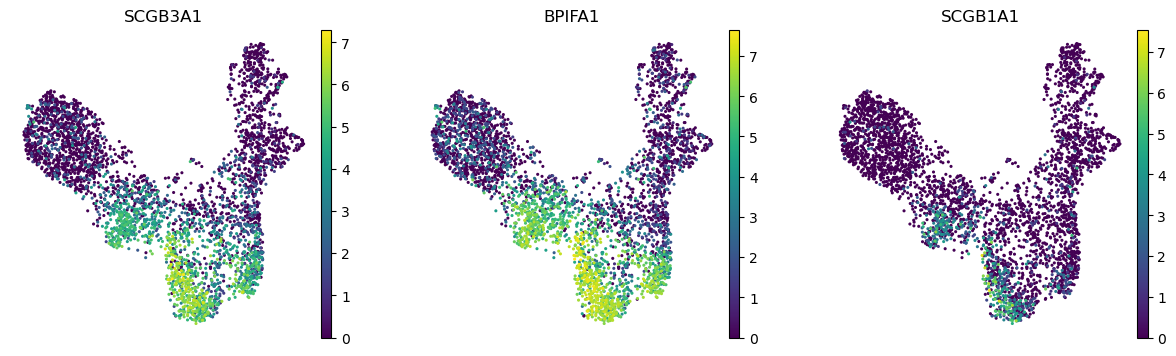

In [72]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["SCGB3A1", "BPIFA1", "SCGB1A1"], s=20, frameon=False)

### c1 and c3 both express secretory markers, but c3 has high levels of Club cell markers CYP2F1, CYP4B1, SCGB1A1 and c1 has higher levels of MUC5B, [AGR2](https://www.proteinatlas.org/ENSG00000106541-AGR2/single+cell), S100P which are more associated with Goblet cells

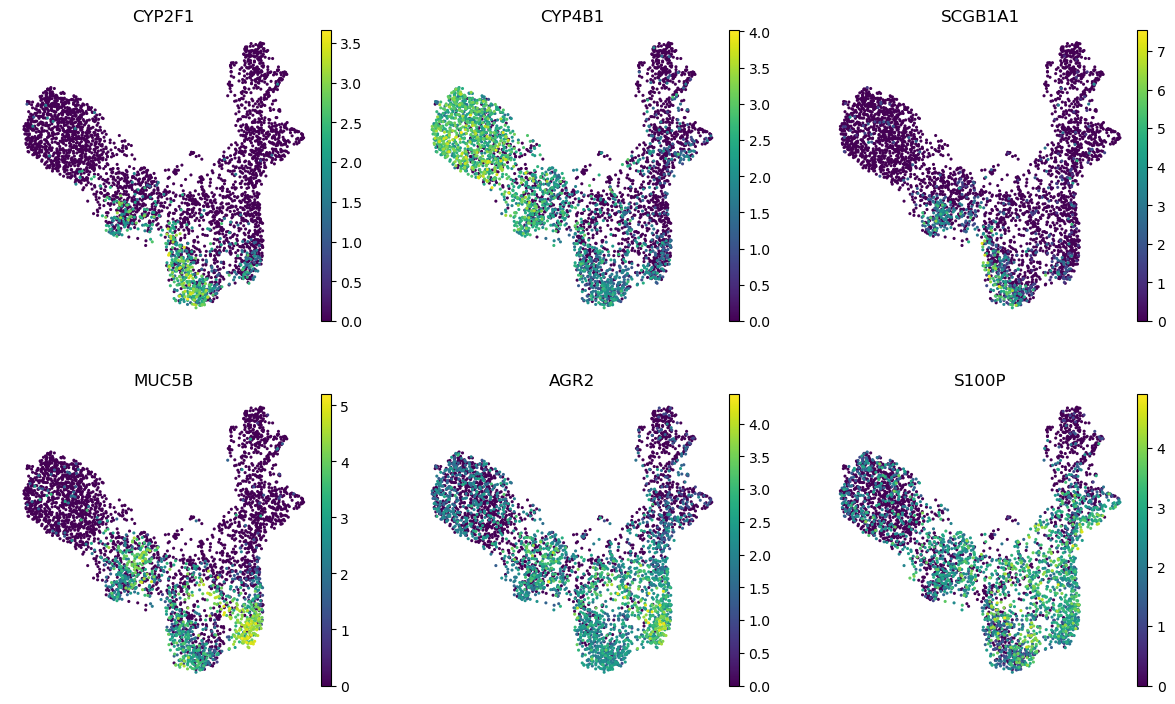

In [73]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(
    adata,
    color=["CYP2F1", "CYP4B1", "SCGB1A1", "MUC5B", "AGR2", "S100P"],
    ncols=3,
    s=20,
    frameon=False,
)

### c4 and c5 both express Basal markers KRT5 and KRT6A.
### c4 has higher levels of KRT13 and SPRR1B, associated with a more differentiated state of Suprabasal cells.
### c5, conversely, has higher levels of COL17A1, a marker of a more basal state; however, many genes expressed in c5 (FN1, LGALS1, CDH6) are not basal-associated and seem to be driven by BMP4 treatment.

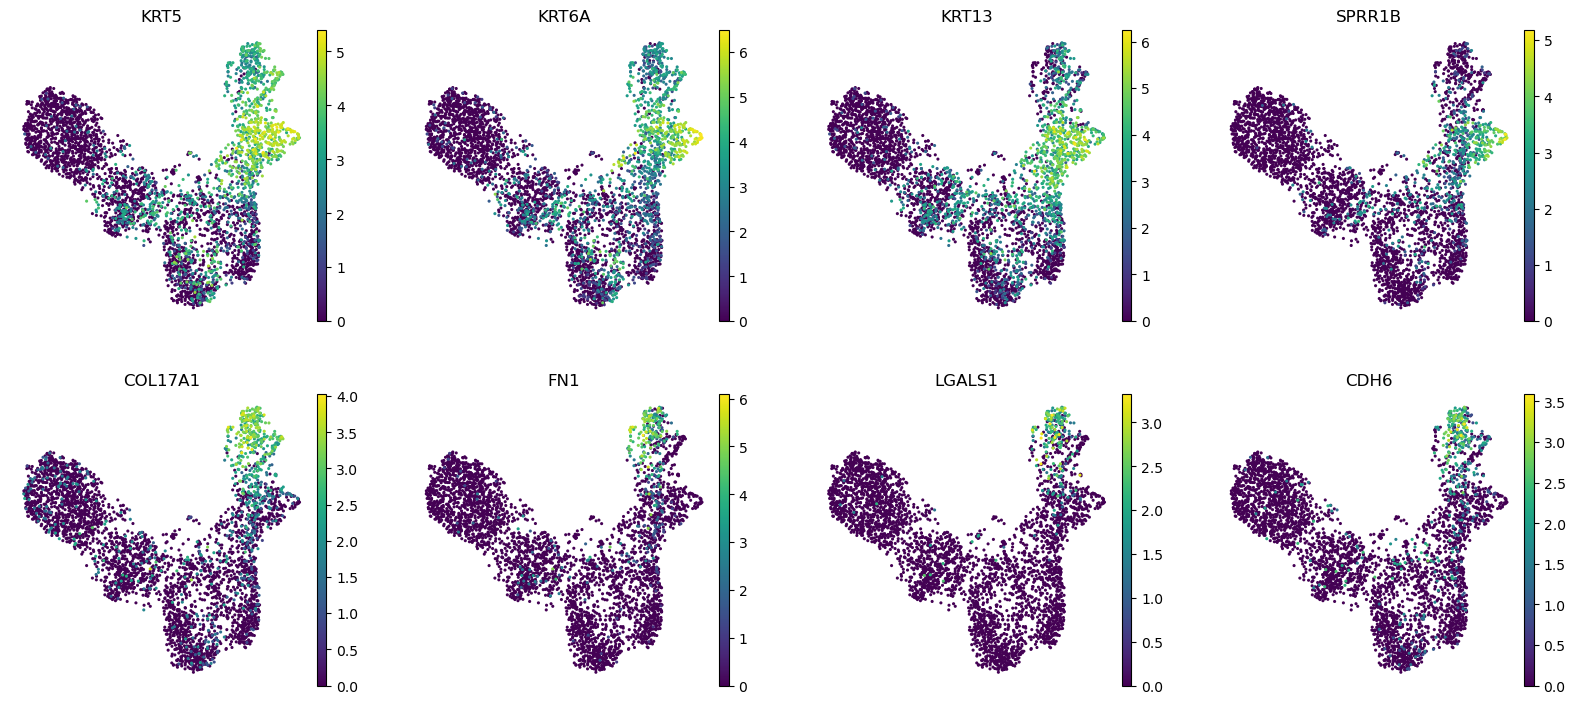

In [74]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(
    adata,
    color=["KRT5", "KRT6A", "KRT13", "SPRR1B", "COL17A1", "FN1", "LGALS1", "CDH6"],
    ncols=4,
    s=20,
    frameon=False,
)

### c6 expresses KIT, AZGP1, and LRMP, which are Tuft cell markers, as well as FOXI1 and HEPACAM2, which are Ionocyte markers. However, since the cluster is very small, we cannot distinguish a clear signal or confidently define the cluster.

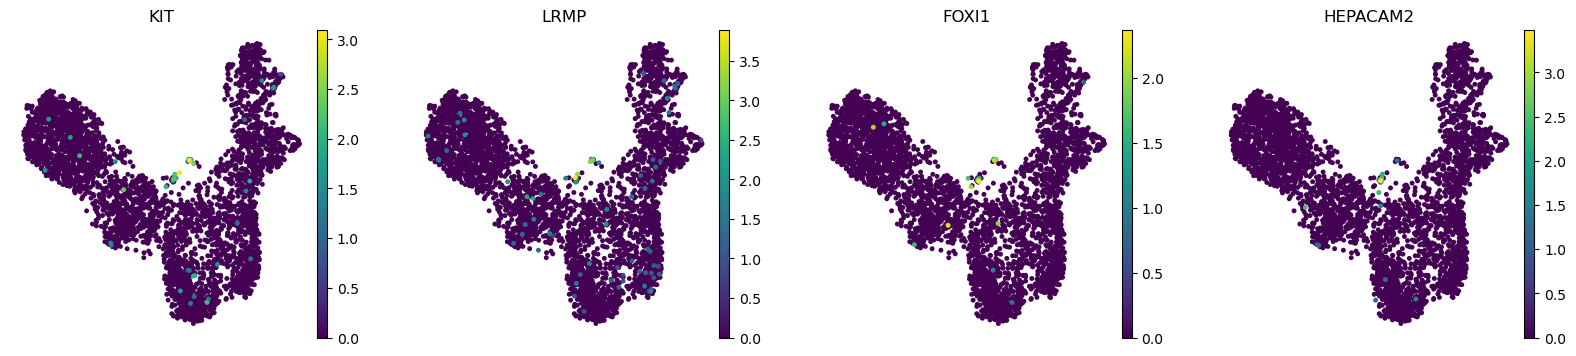

In [75]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(
    adata, color=["KIT", "LRMP", "FOXI1", "HEPACAM2"], ncols=4, s=50, frameon=False
)

# Final annotation of cell types

In [76]:
cell_map = {
    "0": "Ciliated",
    "1": "Goblet",
    "2": "Secretory\nCiliated",
    "3": "Club",
    "4": "Suprabasal",
    "5": "Basal",
    "6": "Tuft\nIonocyte",
}

In [77]:
adata.obs["cell_type"] = adata.obs.leiden.map(cell_map)

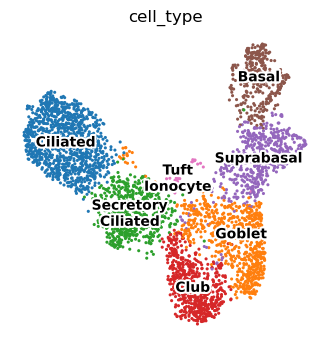

In [78]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(
    adata,
    color=["cell_type"],
    s=20,
    frameon=False,
    legend_loc="on data",
    legend_fontsize=10,
    legend_fontoutline=3,
)

In [79]:
markers_dics = {
    "Basal": ["COL17A1", "FN1", "CDH6"],
    "Suprabasal": ["KRT5", "KRT6A", "KRT13"],
    "Goblet": ["S100P", "AGR2"],
    "Club": ["CYP2F1", "SCGB1A1"],
    "Secretory\nCiliated": ["SCGB3A1", "BPIFA1", "SCGB1A1"],
    "Ciliated": ["RSPH1", "TPPP3", "FOXJ1"],
    "Tuft\nIonocyte": ["KIT", "LRMP", "FOXI1", "HEPACAM2"],
}

In [80]:
adata.obs.cell_type = adata.obs.cell_type.cat.reorder_categories(markers_dics.keys())

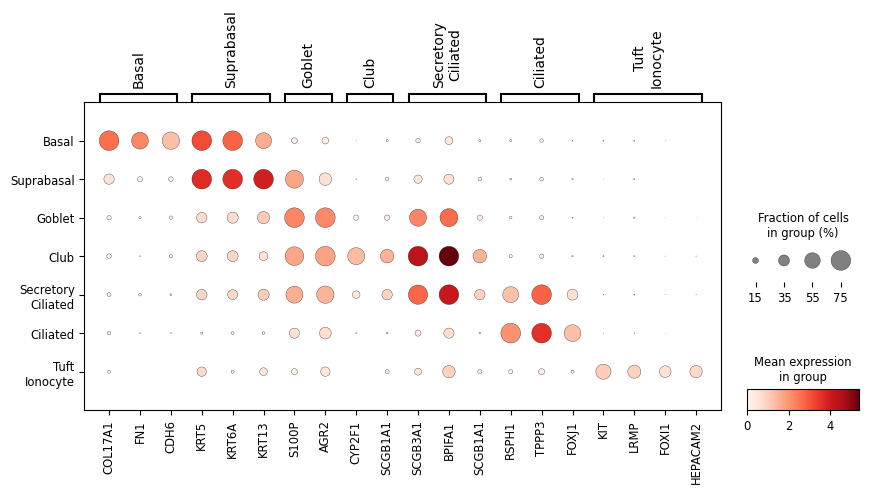

In [81]:
sc.pl.dotplot(
    adata,
    markers_dics,
    groupby="cell_type",
    swap_axes=False,
    expression_cutoff=0.5,
    dot_max=0.75,
    dot_min=0,
    figsize=(10, 4),
    show=False,
);

# Fraction of cell types per condition

In [82]:
summary = pd.crosstab(adata.obs.cell_type, adata.obs.condition)

In [83]:
summary

condition            BMP4_D1  None_D1
cell_type                            
Basal                    258       88
Suprabasal               315      197
Goblet                   218      471
Club                     167      413
Secretory\nCiliated      260      339
Ciliated                 334      771
Tuft\nIonocyte             6       26

#### normalize by total cells per sample

In [84]:
sample_norm = summary.divide(summary.sum(axis=0), axis="columns") * 100

In [85]:
sample_norm

condition              BMP4_D1    None_D1
cell_type                                
Basal                16.559692   3.817787
Suprabasal           20.218228   8.546638
Goblet               13.992298  20.433839
Club                 10.718870  17.917570
Secretory\nCiliated  16.688062  14.707158
Ciliated             21.437741  33.449024
Tuft\nIonocyte        0.385109   1.127983

In [86]:
cluster_norm = sample_norm.divide(sample_norm.sum(axis=1), axis="rows") * 100

In [87]:
cluster_norm

condition              BMP4_D1    None_D1
cell_type                                
Basal                81.264673  18.735327
Suprabasal           70.287928  29.712072
Goblet               40.644403  59.355597
Club                 37.430875  62.569125
Secretory\nCiliated  53.154785  46.845215
Ciliated             39.058124  60.941876
Tuft\nIonocyte       25.451802  74.548198

In [88]:
colors = adata.uns["leiden_colors"]

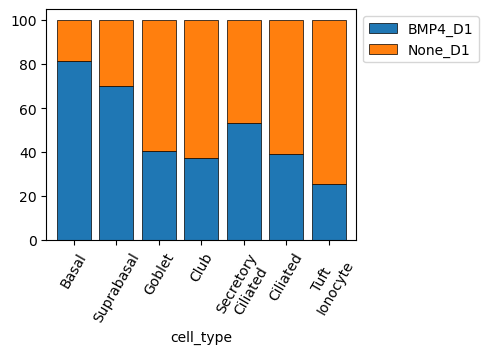

In [89]:
plt.rcParams["figure.figsize"] = (4, 3)
ax = cluster_norm.plot(
    kind="bar", stacked=True, color=colors, width=0.8, edgecolor="black", linewidth=0.5
)
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xticklabels(cluster_norm.index, rotation=60);


### ***In line with initial observations, we see that basal cells are enriched in BMP-treated cells, while non-treated cells seem to show higher levels of differentiation toward other cell types.***

# Epithelial-to-Mesenchymal Transition (EMT) Scoring

#### The literature suggests that [BMP4 is associated with EMT](https://doi.org/10.1038/s41598-019-48190-5), a process [common in cancer and inflammation, but also in embryogenesis and cell differentiation](https://doi.org/10.1172/jci39104).

#### We select a gene set associated with this process from MSigDB (https://www.gsea-msigdb.org/gsea/msigdb/cards/HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION.html) and score the cells based on the sum of normalized counts of transcripts from this gene set.

In [90]:
EMT_genes = (
    "ABI3BP,ACTA2,ADAM12,ANPEP,APLP1,AREG,BASP1,BDNF,BGN,BMP1,CADM1,CALD1,CALU,CAP2,CAPG,CD44,CD59,CDH11,CDH2,CDH6,COL11A1,COL12A1,\
COL16A1,COL1A1,COL1A2,COL3A1,COL4A1,COL4A2,COL5A1,COL5A2,COL5A3,COL6A2,COL6A3,COL7A1,COL8A2,COMP,COPA,CRLF1,CTGF,CTHRC1,CXCL1,CXCL12,\
CXCL6,CYR61,DAB2,DCN,DKK1,DPYSL3,DST,ECM1,ECM2,EDIL3,EFEMP2,ELN,EMP3,ENO2,FAP,FAS,FBLN1,FBLN2,FBLN5,FBN1,FBN2,FERMT2,FGF2,FLNA,FMOD,FN1,\
FOXC2,FSTL1,FSTL3,FUCA1,FZD8,GADD45A,GADD45B,GAS1,GEM,GJA1,GLIPR1,GLT25D1,GPC1,GPX7,GREM1,HTRA1,ID2,IGFBP2,IGFBP3,IGFBP4,IL15,IL32,IL6,\
IL8,INHBA,ITGA2,ITGA5,ITGAV,ITGB1,ITGB3,ITGB5,JUN,LAMA1,LAMA2,LAMA3,LAMC1,LAMC2,LEPRE1,LGALS1,LOX,LOXL1,LOXL2,LRP1,LRRC15,LUM,MAGEE1,MATN2,\
MATN3,MCM7,MEST,MFAP5,MGP,MMP1,MMP14,MMP2,MMP3,MSX1,MXRA5,MYL9,MYLK,NID2,NNMT,NOTCH2,NT5E,NTM,OXTR,PCOLCE,PCOLCE2,PDGFRB,PDLIM4,PFN2,PLAUR,\
PLOD1,PLOD2,PLOD3,PMEPA1,PMP22,POSTN,PPIB,PRRX1,PRSS2,PTHLH,PTX3,PVR,QSOX1,RGS4,RHOB,SAT1,SCG2,SDC1,SDC4,SERPINE1,SERPINE2,SERPINH1,SFRP1,\
SFRP4,SGCB,SGCD,SGCG,SLC6A8,SLIT2,SLIT3,SNAI2,SNTB1,SPARC,SPOCK1,SPP1,TAGLN,TFPI2,TGFB1,TGFBI,TGFBR3,TGM2,THBS1,THBS2,THY1,TIMP1,TIMP3,\
TNC,TNFAIP3,TNFRSF11B,TNFRSF12A,TPM1,TPM2,TPM4,VCAM1,VCAN,VEGFA,VEGFC,VIM,WIPF1,WNT5A"
)
EMT_genes = EMT_genes.split(",")

In [91]:
EMT_count_matrix = adata[:, adata.var.index.isin(EMT_genes)].X.todense()

log1p_reverse_transform = np.exp(EMT_count_matrix) - 1

total_EMT_transcrpts_per_cell = log1p_reverse_transform.sum(axis=1)

adata.obs["log10_EMT_score"] = np.log10(total_EMT_transcrpts_per_cell)

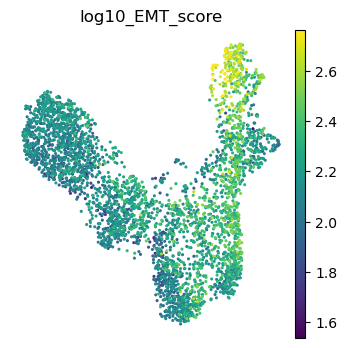

In [92]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["log10_EMT_score"], ncols=3, s=20, frameon=False, vmax="p99.5")

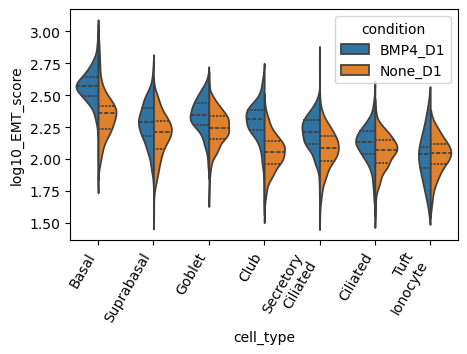

In [93]:
plt.rcParams["figure.figsize"] = (5, 3)
ax = sns.violinplot(
    data=adata.obs,
    x="cell_type",
    y="log10_EMT_score",
    hue="condition",
    split=True,
    inner="quartile",
)

plt.xticks(rotation=60, ha="right");

### ***Basal cells seem to have the highest levels of this signature across all cells, and there is a clear upregulation of genes associated with this process after BMP4 treatment. Interestingly, club cells also appear to be targeted by BMP4 treatment***

# DEG between conditions within basal cluster

#### As a final analysis, we compute the DEGs within the cluster that seems to be mostly associated with BMP4 treatment. Notably, we aim to identify, beyond EMT genes, what else might be differentially expressed with this treatment.

In [94]:
sub = adata[adata.obs.leiden.isin(["5"])].copy()

In [95]:
sub.uns["log1p"]["base"] = None
sc.tl.rank_genes_groups(sub, "condition", method="wilcoxon", key_added="leiden_DEG")

In [96]:
sub.obs.condition.value_counts()

condition
BMP4_D1    258
None_D1     88
Name: count, dtype: int64

In [97]:
result = sub.uns["leiden_DEG"]
groups = result["names"].dtype.names
deg = pd.DataFrame(
    {
        group + "_" + key[:4]: result[key][group]
        for group in groups
        for key in ["names", "pvals_adj", "logfoldchanges"]
    }
)

In [98]:
groups

('BMP4_D1', 'None_D1')

In [99]:
DEF_dfs = {}
for i in groups:
    deg_sub = deg[[f"{i}_name", f"{i}_pval", f"{i}_logf"]].copy()
    deg_sub["logpval_mult_logf"] = -np.log10(
        deg_sub[f"{i}_pval"] + 10 ** (-300)
    ) * np.abs(deg_sub[f"{i}_logf"] ** 2)
    deg_sub = (
        deg_sub[(deg_sub[f"{i}_pval"] < 0.01) & (deg_sub[f"{i}_logf"] > 1.5)]
        .sort_values(by="logpval_mult_logf", ascending=False)
        .head(400)
    )
    DEF_dfs[i] = deg_sub

In [100]:
DEF_dfs["BMP4_D1"]

BMP4_D1_name  BMP4_D1_pval  BMP4_D1_logf  logpval_mult_logf
45       SAMD11  5.588454e-05     29.422123        3681.405064
1           FN1  5.133275e-17      4.967211         401.916423
53        DUSP2  1.746463e-04      5.729281         123.349862
3        PMEPA1  1.893012e-15      2.601594          99.648532
9         PTGS2  4.548522e-11      2.998601          92.992363
2           ID3  7.453430e-17      2.395742          92.565912
21       CXCL14  2.581276e-08      3.413225          88.402937
7          TPM1  9.066512e-12      2.354990          61.241768
67      ST3GAL5  7.360282e-04      4.188519          54.966249
22         KRT7  5.186453e-08      2.659229          51.516768
23       CDKN2B  5.343197e-08      2.656281          51.311371
12      RHOBTB3  3.598701e-10      2.225937          46.792351
82         DLC1  6.064202e-03      4.384006          42.614002
41         BPGM  3.074038e-05      2.953325          39.356768
40       AMIGO2  2.526962e-05      2.822337          36.621008
30      CYP24A1  2.965298e-06      2.492291          34.336820
8         TRAM1  3.448116e-11      1.761060          32.447432
6          IER3  5.984900e-12      1.692019          32.130485
18       TMBIM1  8.649086e-09      1.994464          32.073809
16        PTHLH  1.775347e-09      1.783407          27.832016
15       CDKN1A  7.236999e-10      1.663930          25.306801
27       CDKN2A  1.077213e-06      1.911967          21.815620
38         MALL  1.828477e-05      2.067944          20.261170
31         CDH6  3.124458e-06      1.788788          17.615406
37       DCBLD2  1.268894e-05      1.880995          17.324784
64         LY6D  5.818369e-04      2.289875          16.963850
28     CDC42EP3  2.074823e-06      1.703848          16.498370
69       ENDOD1  9.099978e-04      2.263485          15.579940
50      SLC38A5  1.470921e-04      1.908857          13.964288
70       ERRFI1  9.622200e-04      2.143767          13.864073
63     PPP1R14C  3.808142e-04      1.993328          13.586047
72     IVNS1ABP  1.759351e-03      2.218233          13.554397
36       NFKBIA  6.036619e-06      1.563844          12.764128
54        ZMAT3  1.811137e-04      1.841646          12.691763
48         PDXK  8.461596e-05      1.700898          11.782098
49      SEC61A1  1.365627e-04      1.693143          11.078973
73        CALM3  1.780248e-03      1.965924          10.626495
84       SLC7A8  6.858188e-03      2.115563           9.684275
80         YKT6  4.510813e-03      1.969022           9.094562
78        STRA6  4.131206e-03      1.897858           8.586573
75       SLC7A5  2.251218e-03      1.796590           8.545693
74     SERPINE1  1.982421e-03      1.684212           7.666692
81       TM4SF1  6.011030e-03      1.730128           6.648366
79       SPOCK1  4.224889e-03      1.524429           5.517330

#### We find CDKN1A, CDKN2A, and CDKN2B, which are cell cycle kinase inhibitors. This suggests that BMP4 treatment induces cell cycle arrest in basal cells. CXCL14 is associated with mesenchymal cell states such as [fibroblasts](https://www.proteinatlas.org/ENSG00000145824-CXCL14/single+cell). DUSP2 is [suggested](https://doi.org/10.1172/JCI44362) to mediate negative regulation of MAPK signaling and cell proliferation.